In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData
import seaborn as sns
sns.set_style("whitegrid")

In [137]:
#reduced chi2 calculations
def redchi2(f, x, y, y_err, *args):
    sum = 0
    for i in range(len(x)):
        sum += np.square((f(x[i], *args) - y[i])/(y_err[i]))
    dof = len(y) - len(args)
    rc2 = (sum)/dof
    return rc2

In [138]:
#coeff of determination: R^2
def R2(f, x, y, y_err, *args):
    ybar=np.mean(y)
    ss_tot = np.sum((y-ybar)**2)
    ss_res = np.sum((y-f(x, *args))**2)
    Rsq = 1-(ss_res/ss_tot)
    return Rsq

In [139]:
df = pd.read_csv('../data/unattpowvsattpow.csv',delimiter=',', header=0)
#read all columns data into variables
current = np.array(df['I (mA)'])
current_error = np.array(df['delta I'])
unatt_pow = np.array(df['Pnoatt [muW]'])
unatt_pow_error = np.array(df['delta Pnoatt'])
att_pow = np.array(df['Patt [muW]'])
att_pow_error = np.array(df['delta Patt'])

## Calibration of Attenuator

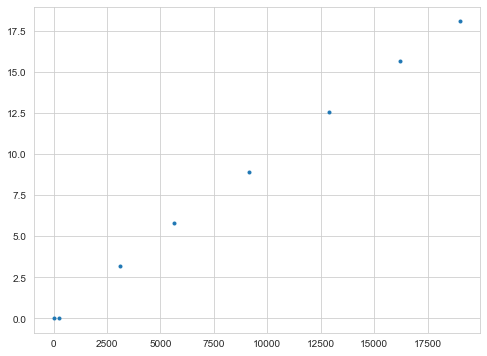

In [140]:
#Slicing req values
unatt_pow_cut = unatt_pow[(unatt_pow>=28.2) & (unatt_pow<=19000)]
att_pow_cut = att_pow[(unatt_pow>=28.2) & (unatt_pow<=19000)]
unatt_pow_error_cut = unatt_pow_error[(unatt_pow>=28.2) & (unatt_pow<=19000)]
att_pow_error_cut = att_pow_error[(unatt_pow>=28.2) & (unatt_pow<=19000)]
plt.figure(figsize=(8, 6))
plt.plot(unatt_pow_cut, att_pow_cut,'.')
plt.show()

### Model for linear fit of attenuated power vs unattenuated power:

$P_{att}=aP_{unatt}+b$

In [141]:
def linear_model(x, a, b):
    return (a*x+b)

In [142]:
#Fit curve using some guess values for a and b
#popt stores optimal parameters
'''
pcov stores covariance matrix
Diagonal entries of cov matrix are variances of fit parameters
Sqrt(diag(pcov)) will give error (std dev) of fit paramaters
'''
popt, pcov = curve_fit(linear_model, unatt_pow_cut, att_pow_cut, sigma = att_pow_error_cut, p0=[1/1000,0], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print("Optimal parameters:","a=",popt[0],"b=",popt[1])
print("Errors in optimal parameters:","delta_a=",perr[0],"delta_b=",perr[1])


Optimal parameters: a= 0.0009947484183711964 b= -0.01635953514068112
Errors in optimal parameters: delta_a= 1.252530749933867e-06 delta_b= 0.006436979200177107


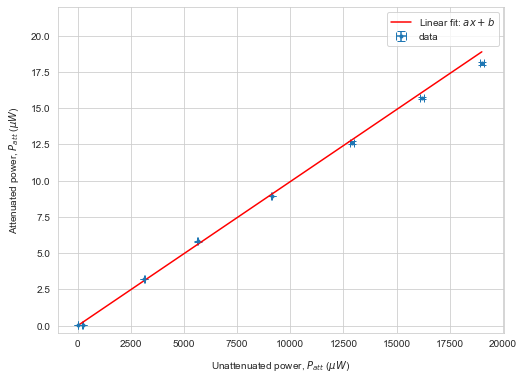

In [146]:
a_opt, b_opt = popt
a_err, b_err = perr
x_model = np.linspace(min(unatt_pow_cut), max(unatt_pow_cut), 1000)
y_model = linear_model(x_model, a_opt, b_opt)
plt.figure(figsize=(8, 6))
plt.ylim(-0.5, 22)
#plt.xlabel(r"Unattenuated power, $P_{unatt}$ ($\mu W$)")
#plt.ylabel(r"Attenuated power, $P_{att}$ ($\mu W$)")
plt.errorbar(unatt_pow_cut, att_pow_cut, yerr = att_pow_error_cut, xerr = unatt_pow_error_cut, fmt = ".", label = 'data', capsize = 4)
plt.ylabel(r"Attenuated power, $P_{att}$ ($\mu W$)", labelpad=10)
plt.xlabel(r"Unattenuated power, $P_{att}$ ($\mu W$)", labelpad=10)
plt.plot(x_model, y_model, color='r', label= r"Linear fit: $ax+b$")
plt.legend(loc = 'upper right')
plt.savefig('../imagesandplots/attvsunattcalib.pdf')
plt.show()

In [147]:
print(redchi2(linear_model, unatt_pow_cut, att_pow_cut, att_pow_error_cut, popt[0], popt[1]))

174.69104360771198


In [148]:
print(R2(linear_model, unatt_pow_cut, att_pow_cut, att_pow_error_cut, popt[0], popt[1]))

0.9972889507581929


## Dependence of Laser Power on Inj. Current

### Calculate unattenuated power from attenuated power for higher values using calibration factor

$P_{unatt}=\dfrac{P_{att}-b}{a}$

$\Delta P_{unatt}=\sqrt{\left(\dfrac{\Delta P_{att}}{a}\right)^{2}+\left(\dfrac{\Delta b}{a}\right)^{2}+\left(\dfrac{\Delta a(P_{att}-b)}{a^{2}}\right)^{2}}$

In [149]:
#Slicing req values
unatt_pow_cut = unatt_pow[current>=90]
att_pow_cut = att_pow[current>=90]
unatt_pow_error_cut = unatt_pow_error[current>=90]
att_pow_error_cut = att_pow_error[current>=90]
unatt_pow_cut = np.round((att_pow_cut-b_opt)/a_opt)
delta1 = (att_pow_error_cut/a_opt)**2
delta2 = (b_err/a_opt)**2
delta3 = ((a_err*(att_pow_cut-b_opt))/(a_opt**2))**2
unatt_pow_error_cut = np.round(np.sqrt(delta1+delta2+delta3))
print(unatt_pow_cut)
print(unatt_pow_error_cut)

[ 21730.  25048.  28064.  30879.  33995.  36508.  40630.  43847.  47064.
  49778.  53095.  56212.  60132.  63249.  65058.  68476.  71190.  74709.
  76820.  80740.  84661.  86470.  89888.  93608.  99137.  98534. 100544.
 106576. 109592. 109592. 114618. 117634. 120650. 121655. 125676. 132713.
 134724. 134724. 141761.]
[104. 106. 107. 108. 109. 111. 113. 115. 117. 119. 121. 123. 126. 128.
 130. 133. 135. 138. 140. 143. 147. 148. 152. 155. 160. 160. 162. 520.
 521. 521. 523. 524. 525. 526. 527. 530. 531. 531. 533.]


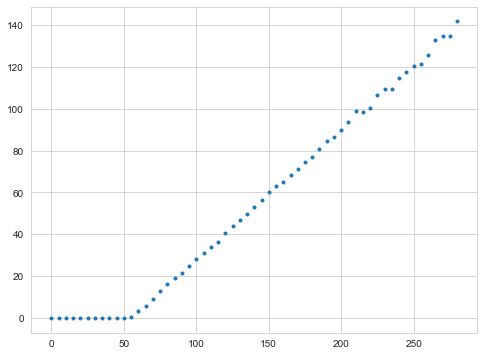

In [162]:
df = pd.read_csv('../data/unattpowvsattpow2.csv',delimiter=',', header=0)
#read all columns data into variables
current = np.array(df['I (mA)'])
current_error = np.array(df['delta I'])
unatt_pow = np.array(df['Pnoatt [muW]'])/1000
unatt_pow_error = np.array(df['delta Pnoatt'])/1000
att_pow = np.array(df['Patt [muW]'])/1000
att_pow_error = np.array(df['delta Patt'])/1000
plt.figure(figsize=(8, 6))
plt.plot(current, unatt_pow,'.')
plt.show()

In [170]:
current_cut = current[(current>50)]
current_error_cut = current_error[(current>50)]
unatt_pow_cut = unatt_pow[(current>50)]
unatt_pow_error_cut = unatt_pow_error[(current>50)]
att_pow_cut = att_pow[(current>50)]
att_pow_error_cut = att_pow_error[(current>50)]

### Fitting the Injection current vs unattenuated power plot (only in linear region)

In [164]:
popt, pcov = curve_fit(linear_model, current_cut, unatt_pow_cut, sigma = unatt_pow_error_cut, p0=[30/40,-30], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print("Optimal parameters:","a=",popt[0],"b=",popt[1])
print("Errors in optimal parameters:","delta_a=",perr[0],"delta_b=",perr[1])

Optimal parameters: a= 0.6223378341101906 b= -34.328878809989675
Errors in optimal parameters: delta_a= 0.0002686873965431595 delta_b= 0.022152721610825963


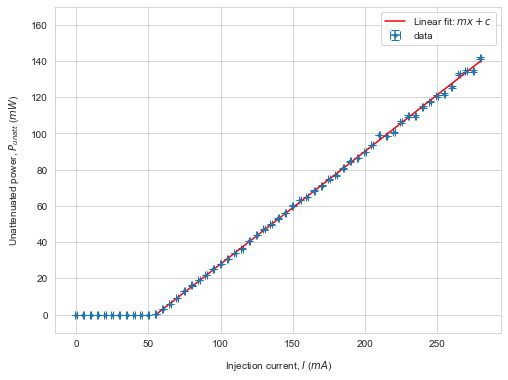

In [173]:
a_opt, b_opt = popt
a_err, b_err = perr
x_model = np.linspace(min(current_cut), max(current_cut), 1000)
y_model = linear_model(x_model, a_opt, b_opt)
plt.figure(figsize=(8, 6))
plt.ylim(-10, 170)
plt.errorbar(current, unatt_pow, yerr = unatt_pow_error, xerr = current_error, fmt = ".", label = 'data', capsize = 4)
plt.xlabel(r"Injection current, $I$ ($mA$)", labelpad=10)
plt.ylabel(r"Unattenuated power, $P_{unatt}$ ($mW$)", labelpad=10)
plt.plot(x_model, y_model, color='r', label= r"Linear fit: $mx+c$")
plt.legend(loc = 'upper right')
plt.savefig('../imagesandplots/injcvsunattpow.pdf')
plt.show()

### Threshold Current:
$I_{0}=-\dfrac{c}{m}$

$\Delta I_{0}=\sqrt{\left(\dfrac{\Delta c}{m}\right)^{2}+\left(\dfrac{c \Delta m}{m}\right)^{2}}$


In [184]:
I0 = -popt[1]/popt[0]
delta1 = (perr[1]/popt[0])**2
delta2 = ((popt[1]*perr[0])/popt[0])**2
I0_err = np.sqrt(delta1+delta2)
print("I0=",I0)
print("Delta I0=", I0_err)

I0= 55.161163163207966
Delta I0= 0.03855825041341215


### Differential Slope Efficiency:

$\dfrac{\partial P}{\partial I}=\dfrac{P}{I}=m$

$\Delta \left(\dfrac{\partial P}{\partial I}\right)=\Delta m$

Same as slope $m$

### Quantum Differential Efficiency:

$\eta=\dfrac{N_{\gamma}}{N_{e}}=\dfrac{e}{h \nu}\dfrac{\partial P}{\partial I}$

$\Delta \eta=\dfrac{N_{\gamma}}{N_{e}}=\left(\dfrac{e}{h \nu}\right)\Delta\left(\dfrac{\partial P}{\partial I}\right)$

In [188]:
e = 1.602e-19
h = 6.626e-34
c = 3e8
wavelength = 987e-9
nu = c/wavelength
print("nu=",nu)
prefact = e/(h*nu)
eta = prefact*popt[0]
print("eta=",eta)
eta_err = prefact*perr[0]
print("delta eta=",eta_err)

nu= 303951367781155.0
eta= 0.49503189582017637
delta eta= 0.00021372448211174854
